# Assignment 1: Tabular Methods

Name: Chuqiao Song

ID: A53239614

This exercise requires you to solve a simple grid-world problem called 'FrozenLake-v0' in OpenAI Gym.  We will solve the problem in two different ways. First we will solve the problem using dynamic programming, thus requiring a model of the system. Second we will do it using model-free temporal difference (Q-Learning). Finally, as a bonus you may also show it learning using a naive approach called hill-climbing. 

### Required for all 
#### Set up environment

In [2]:
%matplotlib inline
import gym
import numpy as np
from matplotlib import pyplot as plt
env = gym.make('FrozenLake-v0')


#### Pre. Test Policy Function
Write a function to test a policy. Return the average rate of successful episodes over 100 trials. 

In [3]:
def testPolicy(policy): #where policy is a 4*4 matrix or 1*16 array
    #%% ---> start of code
    countSuccess = 0
    for i_episode in range(100):
        observation_t = env.reset()
        for timeStep in range(100):            
            action_t = policy[observation_t] #where action_t is the index
            observation_t, reward, done, info = env.step(action_t) #here observation_t = observation_t+1
            if observation_t == 15:
                countSuccess += 1
                #print("Episode finished after {} timesteps, successful".format(timeStep+1))
                break
            elif done:
                #print("Episode finished after {} timesteps, failed".format(timeStep+1))
                break
    percentSuccess = countSuccess / 100.0
    #%% <--- end of code
    return percentSuccess

## Model-based Learning

### 1. Policy Iteration
Perform policy iteration on the Frozenlake example. 


#### 1.1 Find the system model
First, model $T(s,a,s')$ and $R(s,a,s')$ over 100000 randomly initializations.

In [4]:
def learnModel():
    #%% ---> start of code
    env = gym.make('FrozenLake-v0')
    num_observations = env.env.nS
    num_actions = env.env.nA
    T = np.zeros((num_observations, num_actions, num_observations))
    R = np.zeros((num_observations, num_actions, num_observations))

    for _ in range (100000):
        s = np.random.choice(num_observations)
        a_t = np.random.choice(num_actions)
        transitions = env.env.P[s][a_t] # three to one transition
        idx = int(np.random.choice(len(transitions)))
        pr, s_t, reward, done = transitions[idx]
        T [s, a_t, s_t] += 1
        
        if s_t == 15:
            R[s, a_t, s_t] += reward
            
    normalPlane = T.sum(axis =2)
    for i in range(T.shape[2]):
        T[:,:,i] = T[:,:,i]/normalPlane
    #%% <--- end of code
    return R,T


#first learn the model    
[R,T] = learnModel()



#### 1.2 What does the transition model tell you about the stochastic behavior of actions? What does it tell you about the stochasticity  of the rewards? What would you expect an optimal agent's policy to do?

ans: 
1. The transition model tells me, the probability of the agent going to next stage state, given the current stage state if this action takes. For example, if the current satge of the agent is at state S1, there are some probabilities that agent may go to one, two, three etc states of the total state space(say S0, S1, S4). Generally, this transition model can minic the agent operating in real word (having noise).

2. The reward table collected from transition model tells me, the collected reward for an agent going to next stage state given the current stage state if this action is taken.

3. Therefore, optimal agent's policy is chosen based on these two tables; the optimal policy can choose a trajectory that maximaize the long term rewards, and avoid hole places.




#### 1.3 Write a function for Policy Evaluation

In [5]:
#runPolicyEvaluation:
def runPolicyEvaluation(policy,V,R,T,discount_factor):
    #%% ---> start of code
    while True:
        delta = 0
        for s in range (env.env.nS):
            temp = np.copy(V[s])
            # where [:] is for s' which is the next stage states.
            V[s] = T[s, policy[s], :].dot(R[s, policy[s], :] + discount_factor*V[:])
#             RVs_prime = [T[s, policy[s], i]*(R[s, policy[s], i] + discount_factor*V[i]) for i in range(env.env.nS)]
#             V[s] = sum(RVs_prime)
            delta = max(delta, np.abs(temp-V[s]))
        if delta< 1e-8:
            Vnew = V
            break
    #%% <--- end of code
    return Vnew


def runPolicyImprovement(policy, V, R, T, discount_factor):
    policy_stable = True
    for s in range (env.env.nS):
        temp = np.copy(policy[s])
        Q = np.zeros(env.env.nA)
        for aa in range(env.env.nA):
            Q[aa] = T[s, aa, :].dot(R[s, aa, :] + discount_factor*V[:])
#             Q[aa] = sum([T[s, aa, i]*(R[s, aa, i] + discount_factor*V[i]) for i in range(env.env.nS)])
        policy[s] = Q.argmax()
    
        if temp != policy[s]:
            policy_stable = False 
    return policy



#### 1.4 Run Policy iteration.
and show a bar graph of successful runs vs iteration on the policy. Use a discount factor of 0.98, and terminate policy  after 40 iterations of policy updates.  Plot the percentSuccesses at every iteration (i.e. the return of the testPolicy function).

Policy iteration policy: [0 3 3 3 0 0 0 0 3 1 0 0 0 2 1 0]


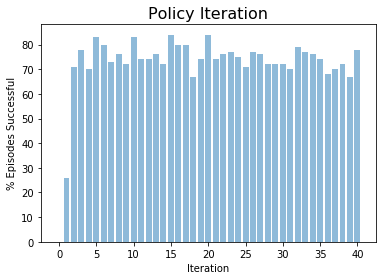

In [6]:
#%% ---> start of code
policy = np.random.choice(env.env.nA, env.env.nS)
V = np.zeros((env.env.nS)) # 1*16
discount_factor = 0.98
percentSuccesses = [testPolicy(policy)]

for i in range (40):
    V = runPolicyEvaluation(policy,V,R,T,discount_factor)
    policy = runPolicyImprovement(policy, V, R, T, discount_factor)
    percentSuccesses.append(testPolicy(policy))

#%% <--- end of code


# plot improvement over time
plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iteration') 
plt.title('Policy Iteration',fontsize=16)  
print('Policy iteration policy:', policy)

## Model-Free Learning

### 2 Q Value-Iteration (Q-Learning)

#### 2.1 Set up a Q learning function
Set your exploration rate to 1-episode_num/total_num_of_episodes for linear convergence from completely random action selection to a greedy policy. Return a set of policies (at 5%, 10%,...100% of the total number of episodes) so that in the later section you can perform policy evaluation on intermediate Q-tables and show progress.

In [20]:
def runQLearning(learning_rate,discount_factor,num_of_episodes,Q0,explore_type='linear'):
    #%% code starts here
    Q = Q0 #Q is 16 * 4 matrix
    Q_saved = []
    #myLR = learning_rate
    print_episodes = int(0.05* num_of_episodes)
    for episode in range(num_of_episodes):
        S = env.reset()   
        myLR = learning_rate/(episode/num_of_episodes+1)
        if explore_type=='linear':
            epsilon = 1 - episode/num_of_episodes
        elif explore_type =='log':
            epsilon = 1000/(1000+episode)
        for step in range(100):
            A = getEpsilonGreedyAction (Q, S, epsilon) #choose A from S using policy deribed from Q
            S_t, R, done, info = env.step(A) # here S is actually S'
            Q[S, A] = Q[S, A] + myLR* (R + discount_factor*Q[S_t,:].max() - Q[S, A]) 
            #update Q matrix
            S = S_t
            if S == 15:
                break
            elif done:
                break
        if (episode+1) % print_episodes == 0:
            Q_saved.append(Q.copy()) #save last Q
    #%% code ends here
    return Q_saved

def getEpsilonGreedyAction(Q, S, epsilon):
    action_idx = int(Q[S].argmax())
    greedy_prob = 1 - epsilon + epsilon/env.env.nA
    not_greedy_prob = epsilon/env.env.nA
    weights = np.full(env.env.nA, not_greedy_prob)
    weights[action_idx] = greedy_prob
    selected_action = np.random.choice(env.env.nA,1,p=weights)
    return int(selected_action)

#### 2.2 Perform Q-learning. 
Show policies during intermediate phases of Q-learning, at 0, 10%, 20%,...,100% of the total episodes during training. Set a learning rate of 0.98 and a discount factor of 0.95. Start with a zero-filled Q-table. Run 10000 episodes. Plot the bar graph of the success rate over time to visualize the improvements to success rate the new policies are providing. 

Q-learning (linear) policy: [0 3 0 3 0 0 0 0 3 1 0 0 0 2 1 0]


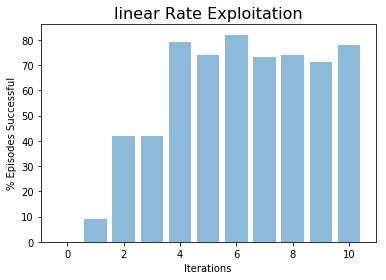

In [19]:
## %% ---> start of code
learning_rate = 0.04
discount_factor = 0.95
num_of_episodes = 10000
percentSuccesses= [0.0]
Q0 = np.zeros((env.env.nS, env.env.nA))
lst_Q = runQLearning(learning_rate,discount_factor,num_of_episodes,Q0,explore_type='linear')
for Q in lst_Q:
    policy = Q.argmax(axis = 1)
    percentSuccesses.append(testPolicy(policy))
percentSuccesses = percentSuccesses[0::2]
#%% <--- end of code

plt.figure()
plt.bar(np.arange(len(percentSuccesses)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iterations')
plt.title('linear Rate Exploitation', fontsize=16)
print('Q-learning (linear) policy:', policy)

#### 2.3 Log Rate Exploration

Run Q-learning for a log exploration rate, $\frac{1000}{1000+\text{episode_num}}$, for 10,000 episodes. Perform policy evaluation and plot the success rate over time. You may find setting Q0 to a random number initialization helps (set it to something very small, i.e. 0.000001\*rand(), since setting it to zero sets a fixed seed).

Q-learning (log) policy: [0 3 1 3 0 0 2 3 3 1 0 1 3 2 1 2]


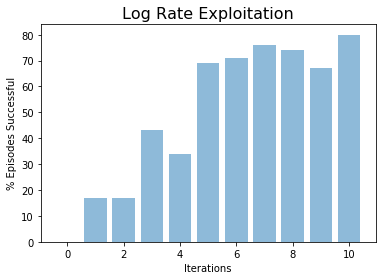

In [27]:
#%% ---> start of code
learning_rate = 0.03
discount_factor = 0.95
num_of_episodes = 10000
percentSuccesses= [0.0]
#Q0 = np.zeros((env.env.nS, env.env.nA))
Q0 = 0.000001*np.random.rand(env.env.nS,env.env.nA)
lst_Q = runQLearning(learning_rate,discount_factor,num_of_episodes,Q0,explore_type='log')
for Q in lst_Q:
    policy = Q.argmax(axis = 1)
    percentSuccesses.append(testPolicy(policy))
percentSuccesses = percentSuccesses[0::2]
#%% <--- end of code

plt.figure()
plt.bar(np.arange(len(percentSuccesses)),100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.ylabel('% Episodes Successful')
plt.xlabel('Iterations')
plt.title('Log Rate Exploitation', fontsize=16)
print('Q-learning (log) policy:', policy)

### BONUS: Hill Climbing (25%, granted only if Parts 1 and 2 are complete)

Demonstrate hill climbing, where your Q values are chosen randomly, and you save improvements, with new Q values to try as $$Q_{test}\leftarrow Q_{best}+rand(S,A)$$
Plot the a bar graph with x-axis labelling the iteration number when an improvement occurred, and y axis as the % of successful episodes. Run on N = 1000 iterations of hill climbing, with 100 episodes per iteration. 

[0 3 1 3 0 2 0 2 3 1 0 0 3 2 1 0] : Hill-climbing policy


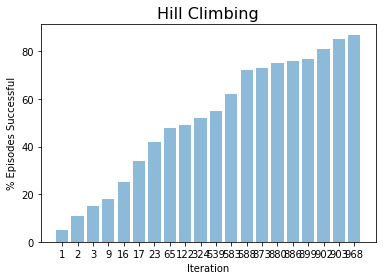

In [34]:
#%% ---> start of code
import copy
def runQLearning(learning_rate,discount_factor,num_of_episodes,Q0,explore_type='linear'):
    Q = Q0 #Q is 16 * 4 matrix
    Q_saved = []
    #myLR = learning_rate
    print_episodes = int(0.05* num_of_episodes)
    for episode in range(num_of_episodes):
        S = env.reset()   
        myLR = learning_rate/(episode/num_of_episodes+1)
        if explore_type=='linear':
            epsilon = 1 - episode/num_of_episodes
        elif explore_type =='log':
            epsilon = 1000/(1000+episode)
        for step in range(100):
            A = getEpsilonGreedyAction (Q, S, epsilon) #choose A from S using policy deribed from Q
            S_t, R, done, info = env.step(A) # here S is actually S'
            Q[S, A] = Q[S, A] + myLR * (R + discount_factor*Q[S_t,:].max() - Q[S, A]) #update Q matrix
            S = S_t
            if S == 15:
                break
            elif done:
                break
        if (episode+1) % print_episodes == 0:
            Q_saved.append(Q.copy()) #save last Q
    return Q_saved

def getEpsilonGreedyAction(Q, S, epsilon):
    action_idx = int(Q[S].argmax())
    greedy_prob = 1 - epsilon + epsilon/env.env.nA
    not_greedy_prob = epsilon/env.env.nA
    weights = np.full(env.env.nA, not_greedy_prob)
    weights[action_idx] = greedy_prob
    selected_action = np.random.choice(env.env.nA,1,p=weights)
    return int(selected_action)

learning_rate = 0.03
discount_factor = 0.95
num_of_episodes = 100

#Qbest = 0.000001*np.random.rand(env.env.nS,env.env.nA)
Qbest = np.zeros((env.env.nS, env.env.nA))
Qbest_policy = Qbest.argmax(axis = 1)
Qbest_accu = 0.0
#testPolicy(Qbest_policy)
improvementsIndex = []
percentSuccesses = []


for climbing_idx in range(1000):
    Qtest = Qbest +  0.0000001*(np.random.rand(env.env.nS,env.env.nA)-0.5)
    lst_Qtested = runQLearning(learning_rate,discount_factor,num_of_episodes,Qtest,explore_type='log')
    
    Qtested = lst_Qtested[-1]
    Qtested_policy = Qtested.argmax(axis = 1)
    Qtested_accu = testPolicy(Qtested_policy)
    
    if Qtested_accu > Qbest_accu:
        #here I get the improvement
        Qbest = copy.deepcopy(Qtested)
        Qbest_accu = copy.deepcopy(Qtested_accu)
        print(Qbest_accu, end = '\r')
        improvementsIndex.append(climbing_idx)
        percentSuccesses.append(Qbest_accu)
        
policy = Qbest.argmax(axis = 1)    
#%% <--- end of code
plt.figure()
plt.bar(np.arange(len(improvementsIndex)), 100*np.array(percentSuccesses), align='center', alpha=0.5)
plt.xticks(np.arange(len(improvementsIndex)),improvementsIndex) 
plt.ylabel('% Episodes Successful')
plt.xlabel('Iteration')
plt.title('Hill Climbing',fontsize=16)
print(policy,': Hill-climbing policy')

In [35]:
percentSuccesses[-1]

0.87